In [33]:
import sql
import pandas as pd
from functools import reduce
import datetime
import matplotlib.pyplot as plt

In [24]:
q='''select t1.ecosystem as ecosystem, advisories, advisory_with_CVEs, packages
from
(select ecosystem, count(distinct a.id) as advisories, count(distinct p.id) as packages
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package'
group by ecosystem) as t1
join
(select ecosystem, count(distinct a.id) as advisory_with_CVEs
from advisoryCVE aC
join advisory a on aC.advisory_id = a.id
join package p on a.package_id = p.id
where type != 'Malicious Package'
group by ecosystem) as t2
on t1.ecosystem = t2.ecosystem
order by advisories desc;'''
df = pd.DataFrame(sql.execute(q))

In [25]:
df['non-CVEs (%)'] = df['advisories'] - df['advisory_with_CVEs']
df['non-CVEs (%)'] = round (df['non-CVEs (%)'] / df['advisories'] * 100 , 2)
df['non-CVEs (%)'].median()

25.03

In [26]:
df

,ecosystem,advisories,advisory_with_CVEs,packages,non-CVEs (%)
0,Maven,2303,1891,1266,17.89
1,npm,1181,682,920,42.25
2,Composer,882,660,253,25.17
3,pip,687,516,333,24.89
4,cocoapods,367,367,37,0.00
5,RubyGems,336,233,174,30.65
6,NuGet,306,251,112,17.97
7,Go,272,202,227,25.74


In [27]:
q='''select *
from advisory a
join package p on a.package_id = p.id
where a.type != 'Malicious Package'
and a.id not in
(select distinct advisory_id
    from advisoryCVE)'''
df = pd.DataFrame(sql.execute(q))
df['since_disclose'] = (datetime.date.today() - df['disclose_date']).dt.days
df['since_publish'] = (datetime.date.today() - df['publish_date']).dt.days
df['since_disclose'].median(), df['since_publish'].median()
p = df.groupby('ecosystem')[['since_publish']].median()
d = df.groupby('ecosystem')[['since_disclose']].median()
pd.merge(p,d,on='ecosystem')

,since_publish,since_disclose
ecosystem,,
Composer,864,945
Go,325,460
Maven,632,764
NuGet,1523,1526
RubyGems,1338,2468
npm,763,886
pip,1106,1400


In [28]:
q = '''select * from
( select * from
    (select id, publish_date as snyk_publish, disclose_date, package_id
    from advisory
    where type != 'Malicious Package') as adv
    join
    (select advisory_id, min(publish_date) as cve_publish
    from advisoryCVE
    group by advisory_id) as cve
    on adv.id = cve.advisory_id
        where cve_publish > snyk_publish) as sub
join package p
    on p.id = sub.package_id;
'''
df = pd.DataFrame(sql.execute(q))
df['cve_delay'] = (df['cve_publish'] - df['snyk_publish']).dt.days
df['delay_from_disclose'] = (df['cve_publish'] - df['disclose_date']).dt.days
delay = df.groupby('ecosystem')[['cve_delay']].median()
count = df.groupby('ecosystem')[['id']].count()
disclose = df.groupby('ecosystem')[['delay_from_disclose']].median()
df=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[count, delay, disclose])
df.columns = ['published by snyk before cve', 'median delay from snyk to cve', 'from disclose to cve']
df

,published by snyk before cve,median delay from snyk to cve,from disclose to cve
ecosystem,,,
Composer,11,14.0,14.0
Go,3,2.0,2.0
Maven,44,63.0,82.5
NuGet,1,13.0,13.0
RubyGems,10,13.5,13.5
npm,55,510.0,516.0
pip,9,310.0,310.0


In [29]:
q='''select *
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package' and ecosystem!='cocoapods';'''
df = pd.DataFrame(sql.execute(q))
df['delay'] = (df['publish_date'] - df['disclose_date']).dt.days
df = df.groupby('ecosystem')[['delay']].median()
df

,delay
ecosystem,
Composer,0.0
Go,0.0
Maven,7.0
NuGet,4.5
RubyGems,42.0
npm,3.0
pip,0.0


<AxesSubplot:title={'center':'advisory count over the year'}, xlabel='publish_year'>

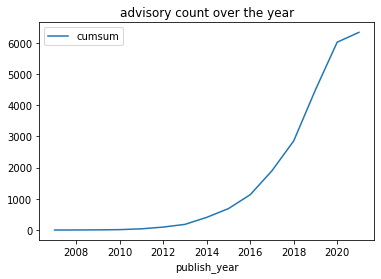

In [43]:
q='''select year(publish_date) as publish_year, count(distinct id) as count
from advisory
where type != 'Malicious Package'
group by year(publish_date);'''
df = pd.DataFrame(sql.execute(q))
df['cumsum']=df['count'].cumsum()
df.plot(x='publish_year',y='cumsum',kind='line', title = 'advisory count over the year')